<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_2/2_2_K_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K Nearest Neighbors

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

## Get the Data

In [2]:
#https://www.kaggle.com/c/titanic/data

url='https://drive.google.com/file/d/1zyYJMa75UXLjmODPRnl4_UrLJ0JKmEOC/view?usp=sharing'
url_='https://drive.google.com/uc?id=' + url.split('/')[-2]
titanic_data = pd.read_csv(url_)

In [3]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Preprocessing

In [5]:
titanic_data.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [6]:
titanic_data = titanic_data.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis = 1)

In [7]:
titanic_data.loc[:, "Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())

In [8]:
set(titanic_data['Embarked']) # порт, з якого пасажир сів на корабель
# C — Cherbourg (Франція)
# Q — Queenstown (Ірландія)
#S — Southampton (Англія, більшість пасажирів сідали саме тут)

{'C', 'Q', 'S', nan}

In [9]:
titanic_data['Embarked'].describe()

,Embarked
count,889
unique,3
top,S
freq,644


In [10]:
titanic_data.loc[:, "Embarked"] = titanic_data["Embarked"].fillna("S")

In [11]:
titanic_data['Sex'] = LabelEncoder().fit_transform(titanic_data['Sex']) # для перетворення категоріальної ознаки стать у числовий формат
# LabelEncoder автоматично знаходить унікальні категорії та кодує їх послідовними числами
# Порядок (хто буде 0, а хто 1) визначається алфавітом: female < male, тому female → 0, male → 1.

In [12]:
titanic_data['Embarked'] = LabelEncoder().fit_transform(titanic_data['Embarked']) # 0, 1, 2
#Note: LabelEncoder має обмеження (штучний порядок) -> OneHotEncoder

In [13]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [14]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


## Train Test Split

In [15]:
X = titanic_data.drop(['Survived'], axis = 1)
y = titanic_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

## Standardize the Variables

Алгоритми машинного навчання, що використовують відстані (наприклад KNN) чутливі до масштабу ознак  

StandardScaler приводить всі ознаки до одного масштабу:  

-середнє значення = 0, стандартне відхилення = 1  

(щоб жодна змінна не «домінувала» тільки через свій масштаб)

In [16]:
scaler = StandardScaler()

In [17]:
scaler.fit(X_train)

StandardScaler()

In [18]:
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test) #  Тестові дані повинні імітувати "нові" невідомі дані,
# тому використовуємо середнє та стандартне відхилення лише за тренувальними даними

## KNN model

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)

In [20]:
knn.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
pred = knn.predict(scaled_X_test)

## Evaluation

In [22]:
print(confusion_matrix(y_test,pred))

[[88 17]
 [20 54]]


In [23]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       105
           1       0.76      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.79      0.79      0.79       179



In [24]:
print(accuracy_score(y_test,pred))

0.7932960893854749


## Choosing a K Value

In [25]:
error_rate = []

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(scaled_X_train,y_train)
    pred_i = knn.predict(scaled_X_test)
    error_rate.append(np.mean(pred_i != y_test))

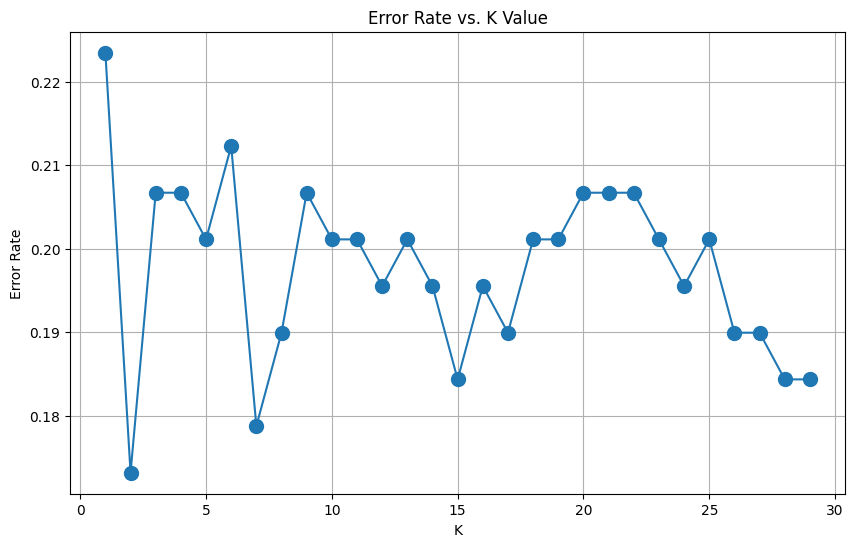

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()

In [27]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(scaled_X_train,y_train)
pred = knn.predict(scaled_X_test)

print(confusion_matrix(y_test,pred))
print()
print(classification_report(y_test,pred))
print()
print(accuracy_score(y_test,pred))

[[90 15]
 [17 57]]

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


0.8212290502793296


**Найважливіші параметри (коротко)**

n_neighbors = 5 — кількість найближчих сусідів, які враховуються при класифікації  

metric = 'minkowski' — метрика для обчислення відстаней  

p = 2 — параметр для Minkowski: p=2 → евклідова відстань, p=1 → мангеттенська

weights ∈ {'uniform', 'distance'} — спосіб врахування сусідів: усі однаково чи ближчі мають більшу вагу, default=’uniform’


In [28]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}